В этом задании будет использоваться датасет boston из sklearn.datasets. Оставьте последние 25% объектов для контроля качества, разделив X и y на X_train, y_train и X_test, y_test.
Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [ ]:
from sklearn import datasets, tree, metrics, ensemble, linear_model
from sklearn.model_selection import train_test_split, cross_validate
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [10]:
data = datasets.fetch_california_housing()

In [27]:
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(15480, 8) (5160, 8)
(15480,) (5160,)


# Задание 1

Бустинг - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки. Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигнориуйте этот множитель при дальнейшем построении алгоритма.

$L(y, z) = (y - z)^2$

$L'_z(y, z) = 2(z - y) => (z - y)$

### Задание 2
Заведите массив для объектов DecisionTreeRegressor (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.
В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X:

`def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]`
    
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics. Возведите результат в степень 0.5, чтобы получить RMSE.

In [45]:
base_algorithms_list = []
coefficients_list = []

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]


for i in range(50):
    difference = gbm_predict(X_train) - y_train
    print(f'Iteration {i}. |difference| = {np.linalg.norm(difference)}')
    decision_tree = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
    decision_tree.fit(X_train, -difference)
    base_algorithms_list.append(decision_tree)
    coefficients_list.append(0.9)

Iteration 0. |difference| = 283.69015310028567
Iteration 1. |difference| = 83.40147413597332
Iteration 2. |difference| = 70.61059905651219
Iteration 3. |difference| = 67.55433005843956
Iteration 4. |difference| = 65.68353652873436
Iteration 5. |difference| = 63.094558041759704
Iteration 6. |difference| = 61.56226743212025
Iteration 7. |difference| = 60.138124909399444
Iteration 8. |difference| = 58.64745559874358
Iteration 9. |difference| = 57.434426443129006
Iteration 10. |difference| = 55.31041289661028
Iteration 11. |difference| = 54.39735835669931
Iteration 12. |difference| = 53.40956722800904
Iteration 13. |difference| = 52.94893612726377
Iteration 14. |difference| = 52.21782220527429
Iteration 15. |difference| = 51.57731950977299
Iteration 16. |difference| = 50.86582956271103
Iteration 17. |difference| = 50.38712760135731
Iteration 18. |difference| = 49.72573796328096
Iteration 19. |difference| = 48.94034707061364
Iteration 20. |difference| = 48.27922063242728
Iteration 21. |diff

In [46]:
metrics.mean_squared_error(y_test, gbm_predict(X_test))**0.5

np.float64(0.8828841468772005)


### Задание 3

Двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Используйте качество работы алгоритма как ответ в пункте 3. В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным.

In [43]:
base_algorithms_list = []
coefficients_list = []

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]


for i in range(50):
    difference = gbm_predict(X_train) - y_train
    print(f'Iteration {i}. |difference| = {np.linalg.norm(difference)}')
    decision_tree = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
    decision_tree.fit(X_train, -difference)
    base_algorithms_list.append(decision_tree)
    coefficients_list.append(0.9 / (1.0 + i))

Iteration 0. |difference| = 283.69015310028567
Iteration 1. |difference| = 83.40147413597332
Iteration 2. |difference| = 74.61827618824049
Iteration 3. |difference| = 71.44866831742014
Iteration 4. |difference| = 69.72084366219
Iteration 5. |difference| = 68.51345446790222
Iteration 6. |difference| = 67.75028238636081
Iteration 7. |difference| = 66.82424050483655
Iteration 8. |difference| = 66.33692614962358
Iteration 9. |difference| = 66.00085831555785
Iteration 10. |difference| = 65.57153354437266
Iteration 11. |difference| = 65.24378766234264
Iteration 12. |difference| = 64.9710453583137
Iteration 13. |difference| = 64.67302708429428
Iteration 14. |difference| = 64.53900664023699
Iteration 15. |difference| = 64.32335635332326
Iteration 16. |difference| = 64.09124913721593
Iteration 17. |difference| = 63.90847426146415
Iteration 18. |difference| = 63.7183491934735
Iteration 19. |difference| = 63.55963295063482
Iteration 20. |difference| = 63.40986938664902
Iteration 21. |difference| 

In [44]:
metrics.mean_squared_error(y_test, gbm_predict(X_test))**0.5

np.float64(0.8163686943620856)

### Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке sklearn, так и в сторонней библиотеке XGBoost, которая имеет свой питоновский интерфейс. На практике XGBoost работает заметно лучше GradientBoostingRegressor из sklearn, но для этого задания вы можете использовать любую реализацию. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера:

  1. С увеличением числа деревьев начиная с некоторого момента качество работы градиентного бустинга не меняется существенно.
  2. С увеличением числа деревьев начиная с некоторого момента градиентный бустинг начинает переобучаться.
  3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться
  4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

#### Зависимость от числа деревьев

In [55]:
trees_counts = [1, 2, 3, 10, 50, 100, 200, 400, 800]
results = []
for n in trees_counts:
    gradient_boosting = ensemble.GradientBoostingRegressor(n_estimators=n, random_state=42)
    gradient_boosting.fit(X_train, y_train)
    rmse = metrics.mean_squared_error(y_test, gradient_boosting.predict(X_test))**0.5
    print(f'Number of trees: {n}. RMSE: {rmse}')
    results.append(rmse)

Number of trees: 1. RMSE: 1.218515286298307
Number of trees: 2. RMSE: 1.1664015066356308
Number of trees: 3. RMSE: 1.1218394231203195
Number of trees: 10. RMSE: 0.9485982767070951
Number of trees: 50. RMSE: 0.81758704461505
Number of trees: 100. RMSE: 0.7389227416097102
Number of trees: 200. RMSE: 0.7204200560474155
Number of trees: 400. RMSE: 0.7150126320269724
Number of trees: 800. RMSE: 0.7113053801709069


Text(0, 0.5, 'RMSE')

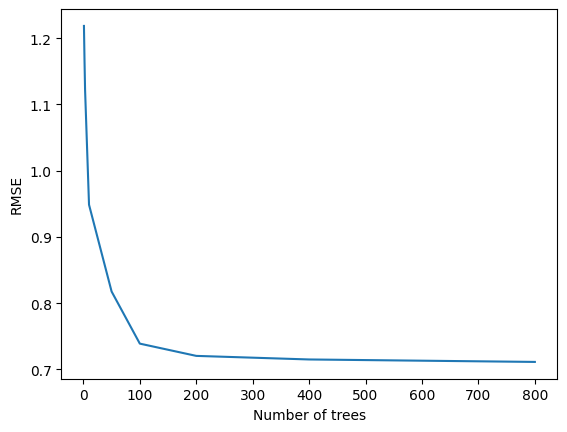

In [56]:
plt.plot(trees_counts, results)
plt.xlabel('Number of trees')
plt.ylabel('RMSE')

1. С увеличением числа деревьев начиная с некоторого момента качество работы градиентного бустинга не меняется существенно.

#### Зависимость от глубины дерева

In [62]:
depths = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 50, 70, 90, 110]
results = []
for n in depths:
    gradient_boosting = ensemble.GradientBoostingRegressor(max_depth=n, random_state=42)
    gradient_boosting.fit(X_train, y_train)
    rmse = metrics.mean_squared_error(y_test, gradient_boosting.predict(X_test))**0.5
    print(f'Number of trees: {n}. RMSE: {rmse}')
    results.append(rmse)

Number of trees: 3. RMSE: 0.7389227416097102
Number of trees: 4. RMSE: 0.7223011873769719
Number of trees: 5. RMSE: 0.7571590736504445
Number of trees: 6. RMSE: 0.7206220977803814
Number of trees: 7. RMSE: 0.7140240264527319
Number of trees: 8. RMSE: 0.728032543219061
Number of trees: 9. RMSE: 0.7412157051852339
Number of trees: 10. RMSE: 0.7471251714929702
Number of trees: 11. RMSE: 0.7781029238151879
Number of trees: 12. RMSE: 0.7811552929984439
Number of trees: 13. RMSE: 0.7995798621239275
Number of trees: 14. RMSE: 0.8075981425868286
Number of trees: 15. RMSE: 0.8252067848354986
Number of trees: 20. RMSE: 0.9252619999427809
Number of trees: 30. RMSE: 0.9475175729200421
Number of trees: 50. RMSE: 0.9446388178576184
Number of trees: 70. RMSE: 0.9446388178576184
Number of trees: 90. RMSE: 0.9446388178576184
Number of trees: 110. RMSE: 0.9446388178576184


Text(0, 0.5, 'RMSE')

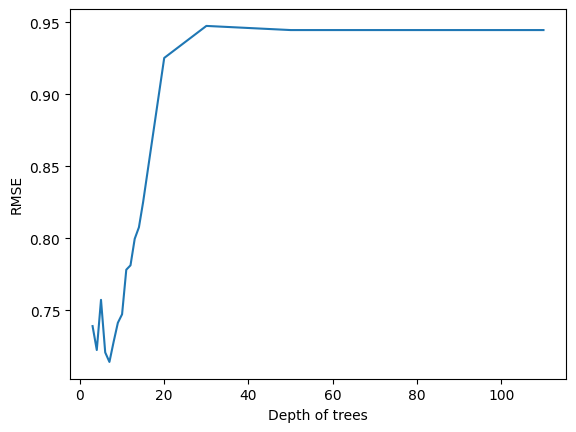

In [63]:
plt.plot(depths, results)
plt.xlabel('Depth of trees')
plt.ylabel('RMSE')
# plt.xscale('log')

3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться

### Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE. В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда.

In [60]:
mse = metrics.mean_squared_error(
    y_test,
    linear_model.LinearRegression().fit(X_train, y_train).predict(X_test)
)
print(f'Linear regression RMSE: {mse**0.5}')

Linear regression RMSE: 0.7848734315922417
